In [1]:
import yt
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progs import ProgModel
import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# Load configuration
stream = open('config.yaml', 'r')
configs = yaml.safe_load(stream)
progenitor_directory = configs['progenitor_directory']
template_directory = configs['template_directory']
runs_directory = configs['runs_directory']

# Constants in CGS units
M_sun = 1.989E33 # Mass of the sun in grams
R_sun = 6.959E10 # Radius of the sun in centimeters
sigma_b = 5.669E-5 # Stefan-Boltzmann constant

# Easy way to convert values into the correct format for MESA model files
def format_number(number):
    return f"{number:.16e}".replace('e', 'D')

In [16]:
def test_plots(checks, zoom_start, zoom_end):
    fig, axs = plt.subplots(len(checks), 2, figsize=(10, len(checks) * 5))
    for i, check in enumerate(checks):
        axs[i, 0].plot(check[2], check[3])
        axs[i, 1].plot(check[2][zoom_start:zoom_end], check[3][zoom_start:zoom_end])
        axs[i, 0].set_xlabel(check[1])
        axs[i, 0].set_ylabel(check[0])
        axs[i, 0].axvline(check[4], ls="--", c="red")
        axs[i, 1].axvline(check[4], ls="--", c="red")
    axs[0, 0].set_title(f"Full Star")
    axs[0, 1].set_title(f"Stitch Region")
    plt.show()

In [ ]:
def shift_to_cell_edge(data):
    """
    Takes values which are cell centered and shifts them to the edge of the cell.

    Parameters:
        data : numpy array (e.g., mass_density)

    Returns:
        shifted_data : numpy array
    """

    shifted_data = np.zeros_like(data)
    shifted_data[:-1] = data[:-1] + 0.5 * (data[1:] - data[:-1])
    shifted_data[-1] = data[-1] + 0.5 * (data[-1] - data[-2])
    return shifted_data

class StirOutput():

    # TODO: Pull some info from progenitor, such as star age and initial redshift
    # TODO: Stitch on progenitor data for cells outside the STIR domain radius
    def __init__(self, checkpoint_path, progenitor_path):
        '''Reads data from a STIR checkpoint at the path and stores the necessary variables.'''
        
        data = yt.load(checkpoint_path).all_data()
        print(data)

        # TODO: Read sukhbold 2016 - Is 'energy' the specific internal energy or the total specific energy?
        # 'mass_edge', 'radius_edge', 'velx_edge', 'density', 'temperature', 'pressure', 'energy', 'entropy', 'ang_vel', 
        # 'abar', 'ye', 'stability', 'neutrons', 'h1', 'he3', 'he4', 'c12', 'n14', 'o16', 'ne20', 'mg24', 'si28', 's32', 
        # 'ar36', 'ca40', 'ti44', 'cr48', 'fe52', 'fe54', 'ni56', 'fe56', 'fe', 'radius', 'mass', 'xi', 'luminosity', 
        # 'velx', 'velz_edge', 'velz', 'sumy', 'zbar'
        
        # Loads in radius and radial velocity but shifts their values from cell center to cell edge for MESA
        self.radius = shift_to_cell_edge(data['r'].v)
        self.radial_velocity = shift_to_cell_edge(data['velx'].v)

        # Loads the progenitor data and finds the start of that data that is outside the STIR domain
        prog_data = ProgModel("15.0", "sukhbold_2016")
        prog_domain = len(prog_data.profile.loc[prog_data.profile['radius_edge'] > np.max(self.radius)])
        stitch_index = prog_data.profile.shape[0] - prog_domain
        original_length = len(self.radius)
        self.cell_count = len(self.radius) + prog_domain

        # Stitches the progenitor data onto the STIR ouput
        self.radius = np.concat((self.radius, prog_data.profile['radius_edge'].values[stitch_index:]))
        self.radial_velocity = np.concat((self.radial_velocity, prog_data.profile['velx_edge'].values[stitch_index:]))
        self.mass_density = np.concat((data['density'].v, prog_data.profile['density'].values[stitch_index:]))
        self.pressure = np.concat((data['pressure'].v, prog_data.profile['pressure'].values[stitch_index:]))
        self.temp = np.concat((data['temp'].v, prog_data.profile['temperature'].values[stitch_index:]))
        self.ye = np.concat((data['ye  '].v, prog_data.profile['ye'].values[stitch_index:])) # Electron fraction

        # Calculating the progenitor volume in each cell and stitching it on
        prog_volume = (4/3) * np.pi * (prog_data.profile['radius_edge'].values[stitch_index:] ** 3 - prog_data.profile['radius_edge'].values[stitch_index - 1:-1] ** 3)
        self.volume  = np.concat((data['cell_volume'].v, prog_volume))

        # TODO: Values that need to be calculated somehow
        self.luminosity = np.zeros(self.cell_count)
        self.xmstar_fraction = np.zeros(self.cell_count)
        self.cc_riemann_velocity = np.zeros(self.cell_count)
        self.mlt_convection_velocity = np.zeros(self.cell_count)
        
        # 'neutrons', 'h1', 'he3', 'he4', 'c12', 'n14', 'o16', 'ne20', 'mg24', 'si28', 's32', 
        # 'ar36', 'ca40', 'ti44', 'cr48', 'fe52', 'fe54', 'ni56', 'fe56', 'fe', 'radius', 'mass', 'xi', 'luminosity', 
        # 'velx', 'velz_edge', 'velz', 'sumy', 'zbar'

        # TODO: Nuclear Network (will need to interpolate values for the STIR domain for now)
        # TODO: Keep in mind that STIR does not simulate the nuclear network so the values within the STIR domain will be inaccurate
        self.neut = np.zeros(self.cell_count)
        self.h1 = np.zeros(self.cell_count)
        self.prot = np.zeros(self.cell_count)
        self.he3 = np.zeros(self.cell_count)
        self.he4 = np.zeros(self.cell_count)
        self.c12 = np.zeros(self.cell_count)
        self.n14 = np.zeros(self.cell_count)
        self.o16 = np.zeros(self.cell_count)
        self.ne20 = np.zeros(self.cell_count)
        self.mg24 = np.zeros(self.cell_count)
        self.si28 = np.zeros(self.cell_count)
        self.s32 = np.zeros(self.cell_count)
        self.ar36 = np.zeros(self.cell_count)
        self.ca40 = np.zeros(self.cell_count)
        self.ti44 = np.zeros(self.cell_count)
        self.cr48 = np.zeros(self.cell_count)
        self.cr60 = np.zeros(self.cell_count)
        self.fe52 = np.zeros(self.cell_count)
        self.fe54 = np.zeros(self.cell_count)
        self.fe56 = np.zeros(self.cell_count) # TODO: This should be 'Fe' in the kepler progenitors. Double check that mass fractions add to 1.
        self.co56 = np.zeros(self.cell_count)
        self.ni56 = np.zeros(self.cell_count)


        # TODO: Figure out if we need these, cause they're not used in MESA input it seems and don't exist in progenitor profile
        #self.specific_internal_energy = np.concat((data['eint'].v, prog_data.profile['density'].values[stitch_index:]))
        #self.total_specific_energy = np.concat((data['ener'].v, prog_data.profile['density'].values[stitch_index:]))
        #self.egrav = np.concat((data['gravitational_potential'].v, prog_profile['density'].values)) # TODO: Double check how this is used in flash_to_snec
        #self.grav_potential = np.concat((data['gpot'].v, prog_data.profile['density'].values))
        #self.total_energy = (self.total_specific_energy - 1.275452534480232E+018 + self.grav_potential) * self.mass_density  * self.volume

        # TODO: Test code - Plotting many of the above values to test if they're stitched on well or have any issues
        test_plots([
            ["log(Radius)", "Cell Index", np.arange(len(self.radius)), np.log(self.radius), original_length],
            ["log(Temperature)", "log(Radius)", np.log(self.radius), np.log(self.temp), np.log(self.radius[original_length])],
            ["log(Mass Density)", "log(Radius)", np.log(self.radius), np.log(self.mass_density), np.log(self.radius[original_length])],
            ["log(Volume)", "log(Radius)", np.log(self.radius), np.log(self.volume), np.log(self.radius[original_length])]
        ], 850, 1050)
    
        '''TODO: Improve calculation
        * Plot the energy profile to find what some small energy would be
        * Find index where total energy is < some small number (10 ** 20 possibly). This is the initial PNS radius/mass.
        * Integrate the specific total energy from that point to the last cell (including progenitor). THis is the overburden energy.
        * Go back to the initial PNS index and integrate the specific total energy with a changing mass until the sum is equal to the overburden energy.
        * The index at that point is where the PNS star should stop.
        '''
        # Determines the PNS mass cut by finding the first unbound cell and summing the mass below that radius
        #bound_index = np.min(np.where(self.total_energy > 10 ** 20))
        #self.pns_masscut = np.sum(self.mass_density[:bound_index]  * self.volume[:bound_index])
        #print(self.pns_masscut)
    
        # TODO: Convert cells for above data into langrangian

        # print(prog_data.profile.keys())
        # 'mass_edge', 'radius_edge', 'velx_edge', 'density', 'temperature', 'pressure', 'energy', 'entropy', 'ang_vel', 
        # 'abar', 'ye', 'stability', 'neutrons', 'h1', 'he3', 'he4', 'c12', 'n14', 'o16', 'ne20', 'mg24', 'si28', 's32', 
        # 'ar36', 'ca40', 'ti44', 'cr48', 'fe52', 'fe54', 'ni56', 'fe56', 'fe', 'radius', 'mass', 'xi', 'luminosity', 
        # 'velx', 'velz_edge', 'velz', 'sumy', 'zbar'

        # Data that will be written in table form in the done_with_edep.mod file
        self.mesa_table_data = pd.DataFrame({
            
            # IMPLEMENTED
            'lnd': np.log(self.mass_density),
            'lnT': np.log(self.temp),
            'lnR': np.log(self.radius),

            # TODO: Need to calculate
            'L': np.zeros(self.cell_count), # TODO: Should I calculate this using the total energy and some dynamical time?
            'dq': np.zeros(self.cell_count), # TODO: Fraction of xmstar=(mstar-mcenter)
            'u': np.zeros(self.cell_count), # TODO: Cell center riemann velocity
            'mlt_vc': np.zeros(self.cell_count), # TODO: MLT convection velocity

            # TODO: Mass Fractions for atomic particles and elements
            # This is tough
            'neut': np.zeros(self.cell_count),
            'h1': np.zeros(self.cell_count),
            'prot': np.zeros(self.cell_count),
            'he3': np.zeros(self.cell_count),
            'he4': np.zeros(self.cell_count),
            'c12': np.zeros(self.cell_count),
            'n14': np.zeros(self.cell_count),
            'o16': np.zeros(self.cell_count),
            'ne20': np.zeros(self.cell_count),
            'mg24': np.zeros(self.cell_count),
            'si28': np.zeros(self.cell_count),
            's32': np.zeros(self.cell_count),
            'ar36': np.zeros(self.cell_count),
            'ca40': np.zeros(self.cell_count),
            'ti44': np.zeros(self.cell_count),
            'cr48': np.zeros(self.cell_count),
            'cr60': np.zeros(self.cell_count),
            'fe52': np.zeros(self.cell_count),
            'fe54': np.zeros(self.cell_count),
            'fe56': np.zeros(self.cell_count), # TODO: This should be 'Fe' in the kepler progenitors. Double check that mass fractions add to 1.
            'co56': np.zeros(self.cell_count),
            'ni56': np.zeros(self.cell_count)

        })
        
        # Reverse the order of rows in the table so that the first cell is the outer radius and last cell is the center
        self.mesa_table_data = self.mesa_table_data.iloc[::-1]  

    def setup_mesa_input(self, model_index):
        '''Takes the STIR output data and writes the necessary information to the MESA input files.''' 

        # IMPLEMENTED
        n_shells = ' ' * (25 - int(np.floor(np.log10(self.cell_count)))) + str(self.cell_count)
        total_mass = np.sum(self.mass_density * self.volume) / M_sun # In units of solar mass
        total_energy = np.sum(self.total_energy) # TODO: Is it okay that the total energy is negative?
        model_number = ' ' * (25 - int(np.floor(np.log10(model_index)))) + str(model_index)

        # TODO: UNIMPLEMENTED, Pull from progenitor
        star_age = 6.3376175628057906E-09
        initial_z = 2.0000000000000000E-02

        # TODO: UNIMPLEMENTED, Need to calculate
        R_center = 3.9992663820663236E+07 # Look to flash_to_snec code
        Teff = 7.2257665281116360E+03 # Use the stefan-boltzmann law after luminosity is calculated
        xmstar = 2.0363416138072876E+34 # How do I calcualte this?
        core_mass = 3.0136524023699760E+33 # Same method as R_center

        # TODO: Do I need to bother?
        # Cumulative energy error
        # Powers that are all 0 in the template header anyway
        # Number of species (may affect number of columns mesa reads?)
        # Average core density?

        file_header = f"""! note: initial lines of file can contain comments
!
           548 -- model for mesa/star, cell center Riemann velocities (u), mlt convection velocity (mlt_vc). cgs units. lnd=ln(density), lnT=ln(temperature), lnR=ln(radius), L=luminosity, dq=fraction of xmstar=(mstar-mcenter) in cell; remaining cols are mass fractions.

                  version_number   'r24.08.1'
                          M/Msun      {format_number(total_mass)}
                    model_number      {model_number}
                        star_age      {format_number(star_age)}
                       initial_z      {format_number(initial_z)}
                        n_shells      {n_shells}
                        net_name   'approx21_cr60_plus_co56.net'
                         species                              22
                          xmstar      {format_number(xmstar)}  ! above core (g).  core mass: Msun, grams:      {format_number(core_mass / M_sun)}    {format_number(core_mass)}
                        R_center      {format_number(R_center)}  ! radius of core (cm).  R/Rsun, avg core density (g/cm^3):      {format_number(R_center / R_sun)}    1.1247695543683205D+10
                            Teff      {format_number(Teff)}
                  power_nuc_burn      0.0000000000000000D+00
                    power_h_burn      0.0000000000000000D+00
                   power_he_burn      0.0000000000000000D+00
                    power_z_burn      0.0000000000000000D+00
                     power_photo      0.0000000000000000D+00
                    total_energy      {format_number(total_energy)}
         cumulative_energy_error      1.3995525796409981D+42
   cumulative_error/total_energy      1.7494407245495471D-09  log_rel_run_E_err     -8.7571007679208037D+00
                     num_retries                               0

                lnd                        lnT                        lnR                          L                         dq                          u                     mlt_vc                   neut                       h1                         prot                       he3                        he4                        c12                        n14                        o16                        ne20                       mg24                       si28                       s32                        ar36                       ca40                       ti44                       cr48                       cr60                       fe52                       fe54                       fe56                       co56                       ni56     
"""

        # Add one line for each cell, consisting of all it's properties
        new_lines = []
        for line_index in range(self.cell_count):

            # Writes the cell/line index 
            spaces = 4 - int(np.floor(np.log10(line_index + 1)))
            new_line = ' ' * spaces + str(line_index + 1)

            # Writes each of the properties
            for column_name in self.mesa_table_data.columns:
                spaces = 5 if self.mesa_table_data.at[line_index, column_name] > 0 else 4
                new_line += spaces * ' ' + format_number(self.mesa_table_data.at[line_index, column_name])

            new_lines.append(new_line)

        # Footer containing info about the previous model
        file_footer = f"""
        
        previous model

               previous n_shells      {n_shells}
           previous mass (grams)      2.3377068540442852D+34 
              timestep (seconds)      4.2684831294390047D-04 
               dt_next (seconds)      5.1221797553268049D-04 """

        # Write all of the above to the done_with_edep.mod file
        with open(f'model_{model_index}/done_with_edep.mod', 'w') as file:
            file.writelines(file_header + '\n'.join(new_lines) + file_footer)

yt : [WARNING  ] 2025-02-18 14:39:30,698 Extending phi dimension to 2PI + left edge.
yt : [WARNING  ] 2025-02-18 14:39:30,699 Extending theta dimension to PI + left edge.
yt : [INFO     ] 2025-02-18 14:39:30,733 Parameters: current_time              = 4.850000223116071
yt : [INFO     ] 2025-02-18 14:39:30,733 Parameters: domain_dimensions         = [240   1   1]
yt : [INFO     ] 2025-02-18 14:39:30,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-02-18 14:39:30,734 Parameters: domain_right_edge         = [1.50000000e+09 3.14159265e+00 6.28318531e+00]
yt : [INFO     ] 2025-02-18 14:39:30,734 Parameters: cosmological_simulation   = 0


YTRegion (stir2_14may19_s15.0_alpha1.25_hdf5_chk_0491): , center=[7.50000000e+08 1.57079633e+00 3.14159265e+00] cm, left_edge=[0. 0. 0.] cm, right_edge=[1.50000000e+09 3.14159265e+00 6.28318531e+00] cm


/mnt/ffs24/home/jdelker/main/projects/osnap/progs/prog_io.py:132: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  network = pd.read_csv(filepath, delim_whitespace=True)


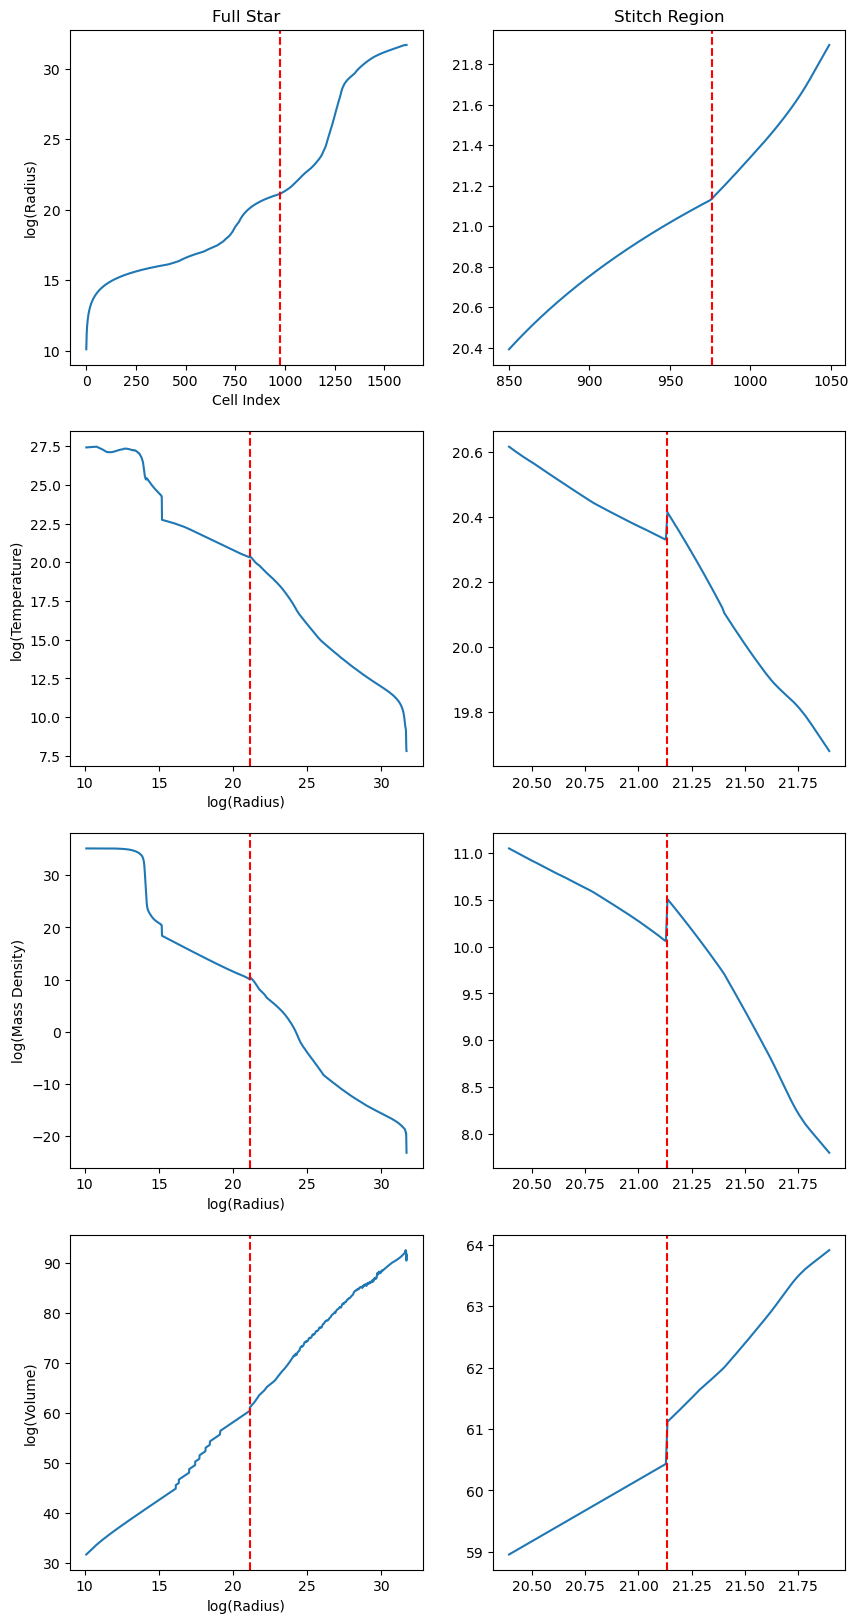

In [18]:
stir_output = StirOutput("stir2_14may19_s15.0_alpha1.25_hdf5_chk_0491", "progenitors/s15.0_presn") #"z9p6_sep4_hyb_a1.0_hdf5_chk_0511")

In [6]:
stir_output.setup_mesa_input(1)

AttributeError: 'StirOutput' object has no attribute 'total_energy'

In [ ]:
stir_output = StirOutput("z9p6_sep4_hyb_a1.0_hdf5_chk_0511", "progenitors/s15.0_presn")

yt : [INFO     ] 2025-02-06 12:27:14,815 Particle file found: z9p6_sep4_hyb_a1.0_hdf5_chk_0511
yt : [WARNING  ] 2025-02-06 12:27:14,824 Extending phi dimension to 2PI + left edge.
yt : [WARNING  ] 2025-02-06 12:27:14,824 Extending theta dimension to PI + left edge.


yt : [INFO     ] 2025-02-06 12:27:14,861 Parameters: current_time              = 5.090000287824025
yt : [INFO     ] 2025-02-06 12:27:14,861 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2025-02-06 12:27:14,862 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-02-06 12:27:14,862 Parameters: domain_right_edge         = [2.40000000e+10 3.14159265e+00 6.28318531e+00]
yt : [INFO     ] 2025-02-06 12:27:14,862 Parameters: cosmological_simulation   = 0


Index(['VERSION 10111 -- Sun Nov  2 22:28:07 2014 UTC -- created by tuguldur on crux.ucolick.org from file ~/survey/data/S_series/s15.0/s15.0#presn -- time 4.21145881946664125E+14 s'], dtype='object')
5.40794759727378e+30


/tmp/ipykernel_1063011/1346186912.py:71: RuntimeWarning: divide by zero encountered in log
  'lnR': np.log(self.radius),
